# Robustness checks on eiPack outputs
Ecological inference (EI) is the industry standard technique — or more properly, family of techniques — for relating demographics to voting history in geographic units. The Article and our Response both use the popular `R` package $eiPack$ to produce estimates of votes by demographic group, in order to count the number of "Minority Opportunity Districts" (MODs) in a given districting plan.

There are several "knobs" one can turn when using $eiPack$. First, a researcher could either choose to run $eiPack$ in parallel on each individual `county`, or instead run it `statewide`. One could either run it in `two phases` — first estimating turnout by demographic group, and then estimating candidate support among those voters who turned out, or in `one phase` — adding a dummy candidate called "Abstain" to account for nonvoters to compute turnout and candidate preference simultaneously.  At the data level, a researcher could choose to use either `CVAP` or `VAP` counts. Lastly, one has to decide how to deal with "problem precincts" (PPs) — precincts that have more reported votes than reported population. This is possible since the reported population can be an undercount: voters could have moved into the precinct between the time the population data was recorded and the election was held. We can think of three possible ways to resolve this case of surplus votes in a precinct:
 * `buffer`: Add a buffer population column to match the total population to total votes
 * `scaleVotes`: Scale the reported votes down to match the total population
 * `scalePop`: Scale the population up to match the total votes
 
We have used $eiPack$ to run EI on nearly every possible combinations of settings of these four knobs. We also tried removing the problem precincts (there were only a few out of Texas's 9082 total), but found that their removal amounted to a negligible change in the EI estimates. Altogether, this means that a run named `scalePop_PPs_CVAP_one_phase_statewide` came from an $eiPack$-produced EI run that scales precincts' population up to match votes if needed, keeps all the problem precincts in, uses CVAP, and was run in one-phase, statewide. This particular setting is the setting we prefer, for reasons laid out in the Response.

In [1]:
from helpers import *
import matplotlib.pyplot as plt
import seaborn as sns

## Variation in MOD count
The first check we want to perform is to see how re-running EI might affect the count of MODs on Texas's enacted House district plan. Our function `calculate_chen_MODs()` (found in the `helpers.py` file in this directory) aggregates the EI-estimated vote totals in each precinct up to the Texas Statehouse district level, and then counts the total number of MODs according to the definition found in the Article. We want to see whether the stochastic nature of EI ends up giving differing numbers of MODs — and if so, we want to know whether different EI settings give more or less variation.

preferred EI, run 1: 51 MODs
preferred EI, run 2: 51 MODs
preferred EI, run 3: 51 MODs
preferred EI, run 4: 51 MODs
preferred EI, run 5: 51 MODs
preferred EI, run 6: 51 MODs
preferred EI, run 7: 51 MODs
preferred EI, run 8: 51 MODs
preferred EI, run 9: 51 MODs
preferred EI, run 10: 51 MODs

article EI, run 1: 45 MODs
article EI, run 2: 45 MODs
article EI, run 3: 44 MODs
article EI, run 4: 45 MODs
article EI, run 5: 45 MODs
article EI, run 6: 44 MODs
article EI, run 7: 44 MODs
article EI, run 8: 44 MODs
article EI, run 9: 45 MODs
article EI, run 10: 44 MODs
article EI, run 11: 45 MODs
article EI, run 12: 44 MODs
article EI, run 13: 44 MODs
article EI, run 14: 45 MODs
article EI, run 15: 45 MODs
article EI, run 16: 45 MODs
article EI, run 17: 45 MODs
article EI, run 18: 44 MODs
article EI, run 19: 45 MODs
article EI, run 20: 45 MODs

unstable EI, run 1: 36 MODs
unstable EI, run 2: 34 MODs
unstable EI, run 3: 35 MODs
unstable EI, run 4: 35 MODs
unstable EI, run 5: 34 MODs
unstable EI, run

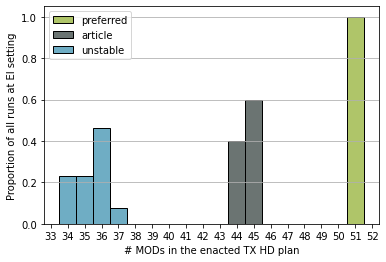

In [2]:
preferred = "scalePop_PPs_CVAP_one_phase_statewide_" # our preferred EI setting
article   = "scaleVotes_PPs_VAP_two_phase_" # the setting used in the Article
unstable  = "buffer_PPs_VAP_two_phase_" # the most unstable setting we've found

preferred_MODs = []
article_MODs = []
unstable_MODs = []

for i in range(1,11):
    run = preferred + str(i)
    MODs = calculate_chen_MODs(run)
    preferred_MODs.append(MODs)
    print(f"preferred EI, run {i}: {MODs} MODs")
print("")
for i in range(1,21):
    run = article + str(i)
    MODs = calculate_chen_MODs(run)
    article_MODs.append(MODs)
    print(f"article EI, run {i}: {MODs} MODs")
print("")
for i in range(1,14):
    run = unstable + str(i)
    MODs = calculate_chen_MODs(run)
    unstable_MODs.append(MODs)
    print(f"unstable EI, run {i}: {MODs} MODs")
    
# Plotting the # MODs, colored by EI setting
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(preferred_MODs, 
             stat="probability", 
             discrete=True, 
             color="#95b237", 
             label="preferred")
sns.histplot(article_MODs, 
             stat="probability", 
             discrete=True, 
             color="#394543", 
             label="article")
sns.histplot(unstable_MODs, 
             stat="probability", 
             discrete=True, 
             color="#3f92b1", 
             label="unstable")

ax.set_xlabel("# MODs in the enacted TX HD plan")
ax.set_ylabel("Proportion of all runs at EI setting")
ax.set_xticks(np.arange(33, 53, 1))
ax.grid(axis='y')
ax.legend()
plt.show()

Different EI settings produce varying levels of variation in MOD counts (`unstable`, aptly named, has the most variation — one could count between 34-37 MODs in the enacted TX HD plan, depending on the run). Strikingly, these  settings also *center* the number of MODs in significantly different places. We explore this phenomenon in the next section.

## The byCounty Effect
Why might the Article's EI setting and the preferred EI setting produce different numbers of MODs on the same districting plan? Here, we isolate one knob — choosing to run EI county-by-county vs. running it statewide. First, we notice that the byCounty MOD count is lower than the statewide one.

In [3]:
byCounty = "scalePop_PPs_CVAP_one_phase_2"
statewide = "scalePop_PPs_CVAP_one_phase_statewide_1"
print(f"byCounty  EI: {calculate_chen_MODs(byCounty)}")
print(f"statewide EI: {calculate_chen_MODs(statewide)}")

byCounty  EI: 49
statewide EI: 51


The `statewide` EI, which is the same as our `preferred` EI setting, produces 51 MODs. But the `byCounty` setting, which is identical to `statewide` save for running it county-by-county, produces 2 fewer MODs. We can compare the two runs more granularly using `compare_runs()`, below. You can find the source code for `compare_runs()` in `helpers.py`.

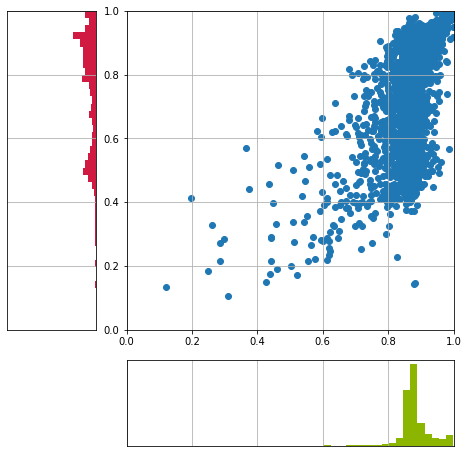

In [4]:
compare_runs(statewide, byCounty)

Here, we have the `statewide` run on the x-axis, and the `byCounty` run on the y-axis. We are comparing the Obama share of the Black vote in the 2012 General election, by precinct. Using the histogram along the x-axis, we see that the statewide run reports high levels of Obama support, whereas the y-axis shows that the `byCounty` run reports a large share of precincts where Black voters are roughly evenly split between Obama and Romney, which seems fairly implausible.

We can use `compare_runs(run1, run2)` to compare Black Obama support in Texas's 2012 Presidential General election for some pairs of EI runs in our dataset, as shown below. The same EI setting was run multiple times, with each distinct run suffixed with a `_1`, `_2`, etc., so we can see how much of an effect we expect to see just due to the probabilistic nature of EI.

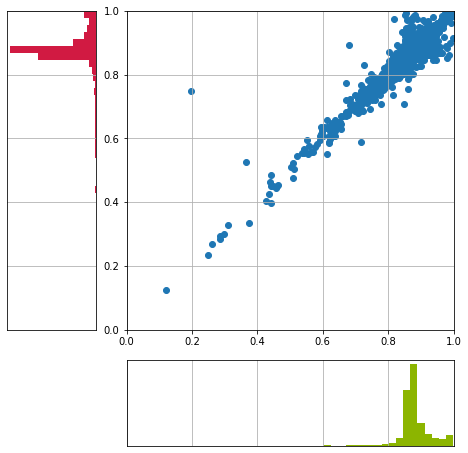

In [5]:
compare_runs("scalePop_PPs_CVAP_one_phase_statewide_1", "scalePop_PPs_CVAP_one_phase_statewide_2")

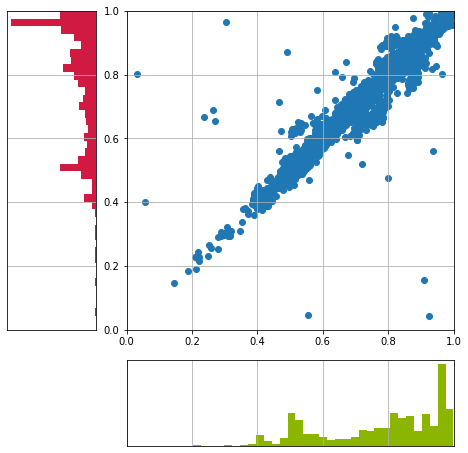

In [6]:
compare_runs("scaleVotes_PPs_VAP_two_phase_1", "scaleVotes_PPs_VAP_two_phase_2")

## Exploring Problem Precincts
If you're interested in taking a look at the "problem precincts" mentioned earlier, here they are.

In [7]:
df = pd.read_csv("../resources/TX_data_for_Chen_EI.csv")
df.head()

,CNTY_x,CNTYVTD,VAP,BVAP,HVAP,CVAP_2012,BCVAP_2012,HCVAP_2012,Obama,Romney
0,1,10001,2341.0,368.0,217.0,1858,281,41,261,754
1,1,10002,2732.0,188.0,135.0,2995,237,199,228,1179
2,1,10003,1345.0,92.0,96.0,1225,54,34,108,650
3,1,10004,1684.0,52.0,47.0,1789,90,11,128,729
4,1,10005,366.0,3.0,12.0,356,0,4,13,174


Let's suppose we're working with `CVAP`. A problem precinct occurs when there are more votes that total population, i.e. `TOTVOTES > CVAP`.

In [8]:
cvap_pps = df[df["CVAP_2012"] < (df["Obama"] + df["Romney"])]
cvap_pps_nonzero = cvap_pps[cvap_pps["VAP"] > 0]
cvap_pps_big = cvap_pps[cvap_pps["VAP"] > 1000]
print(f"There are {len(cvap_pps)} CVAP PPs, {len(cvap_pps) - len(cvap_pps_nonzero)} of which have CVAP = 0.")

There are 171 CVAP PPs, 55 of which have CVAP = 0.


These problem precincts tend to be ones with lower population, as shown below.

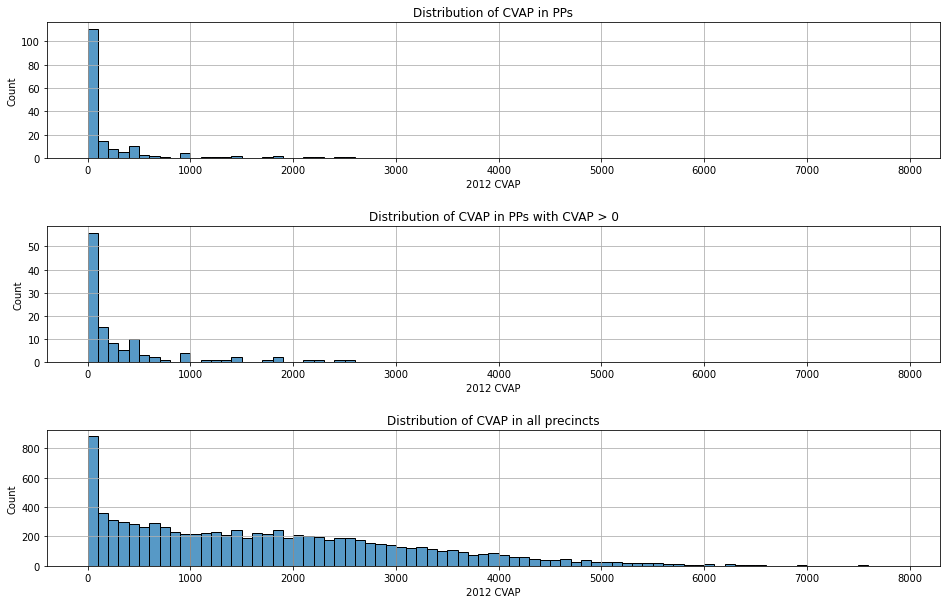

In [9]:
fig, ax = plt.subplots(3,1, figsize=(16,10))

ax[0].set_title("Distribution of CVAP in PPs")
sns.histplot(cvap_pps["CVAP_2012"],
             bins=np.arange(0,8000,100),
             ax = ax[0])


ax[1].set_title("Distribution of CVAP in PPs with CVAP > 0")
sns.histplot(cvap_pps_nonzero["CVAP_2012"],
             bins=np.arange(0,8000,100),
             ax = ax[1])

ax[2].set_title("Distribution of CVAP in all precincts")
sns.histplot(df["CVAP_2012"],
             bins=np.arange(0,8000,100),
             ax = ax[2])

for i in range(3):
    ax[i].set_xlabel("2012 CVAP")
    ax[i].grid()
#     ax[i].set_ylim(0,900)

plt.subplots_adjust(hspace=0.5)

plt.show()

Above, we see that problem precincts are disproportionally the ones with smaller total `CVAP`. While the visible tail of the distribution of `CVAP` overall extends past 7000, there are only a couple problem precincts that have `CVAP` greater than 2000. In fact, about one third of these problem precincts have zero `CVAP`.

In [2]:
original_run_dict = {
    "original_14R_US_Sen":["2014 U.S. Senate - Primary Runoff", "AlameelD_14R_US_Sen", "RogersD_14R_US_Sen"],
    "original_16P_President":["2016 U.S. President - Primary", "ClintonD_16P_President", "SandersD_16P_President"], # ugh
    "original_18P_Lt_Governor":["2018 Lt. Governor - Primary", "CooperD_18P_Lt_Governor", "CollierD_18P_Lt_Governor"], # should only be B?
    "original_12G_President":["2012 President - General", "ObamaD_12G_President", "RomneyR_12G_President"],
    "original_16G_RR_Comm_1":["2016 RR Commissioner 1 — General", "YarbroughD_16G_RR_Comm_1", "ChristianR_16G_RR_Comm_1"],
    "original_18G_Governor":["2018 Governor - General", "ValdezD_18G_Governor", "AbbottR_18G_Governor"],
    "original_18G_Comptroller":["2018 Comptroller - General", "ChevalierD_18G_Comptroller", "HegarR_18G_Comptroller"],
    "original_18G_Lt_Governor":["2018 Lt. Governor - General", "CollierD_18G_Lt_Governor", "PatrickR_18G_Lt_Governor"],
    "original_18G_Land_Comm":["2018 Land Commissioner - General", "SuazoD_18G_Land_Comm", "BushR_18G_Land_Comm"]
}

preferred_run_dict = {
    "preferred_14R_US_Sen":["2014 U.S. Senate - Primary Runoff", "AlameelD_14R_US_Sen", "RogersD_14R_US_Sen"],
    "preferred_16P_President":["2016 U.S. President - Primary", "ClintonD_16P_President", "SandersD_16P_President"], # ugh
    "preferred_18P_Lt_Governor":["2018 Lt. Governor - Primary", "CooperD_18P_Lt_Governor", "CollierD_18P_Lt_Governor"], # should only be B?
    "preferred_12G_President":["2012 President - General", "ObamaD_12G_President", "RomneyR_12G_President"],
    "preferred_16G_RR_Comm_1":["2016 RR Commissioner 1 — General", "YarbroughD_16G_RR_Comm_1", "ChristianR_16G_RR_Comm_1"],
    "preferred_18G_Governor":["2018 Governor - General", "ValdezD_18G_Governor", "AbbottR_18G_Governor"],
    "preferred_18G_Comptroller":["2018 Comptroller - General", "ChevalierD_18G_Comptroller", "HegarR_18G_Comptroller"],
    "preferred_18G_Lt_Governor":["2018 Lt. Governor - General", "CollierD_18G_Lt_Governor", "PatrickR_18G_Lt_Governor"],
    "preferred_18G_Land_Comm":["2018 Land Commissioner - General", "SuazoD_18G_Land_Comm", "BushR_18G_Land_Comm"]
}

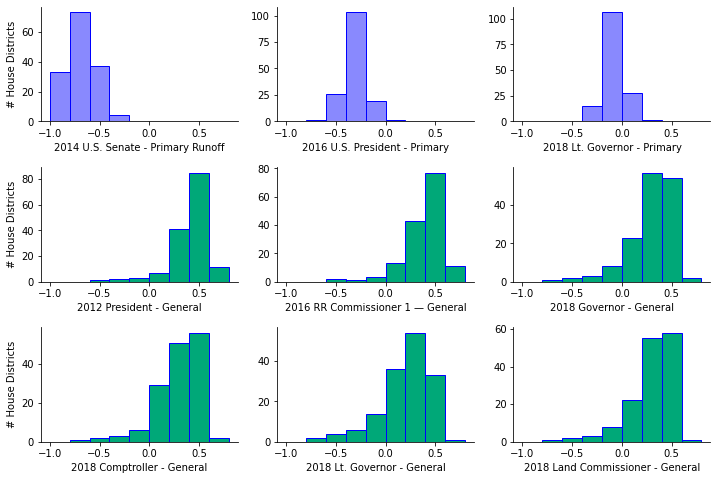

In [5]:
make_full_f4(preferred_run_dict)